# **Предсказание результатов студентов**

# Выбор и загрузка dataset


Kaggle Dataset "Student Performance Prediction - A dummy dataset of 40,000 student data" привлёк моё внимание из-за близости мне темы образования и большой выборки студентов в dataset.

Вот краткое описание dataset c Kaggle:

Этот dataset предназначен для прогнозирования того, получит ли студент зачёт или нет, на основе различных академических и демографических факторов. Он содержит 40 000 записей об учениках с такими атрибутами, как привычки в учёбе, посещаемость, предыдущие оценки и многое другое. Набор данных также имеет проблемы, такие как пропущенные значения, неверные данные и шум, что делает его идеальным для практической очистки данных, исследовательского анализа данных (EDA) и разработки функциональных возможностей.

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"seniababenko","key":"141cfe94654a37d63f3cfa4681807a1e"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d souradippal/student-performance-prediction

Dataset URL: https://www.kaggle.com/datasets/souradippal/student-performance-prediction
License(s): MIT
100% 381k/381k [00:00<00:00, 752kB/s]
100% 381k/381k [00:00<00:00, 751kB/s]


In [5]:
from IPython.core.display import clear_output
!unzip '/content/student-performance-prediction.zip' -d '/content/student-performance-prediction' #разархивация
clear_output()

#Библиотеки

Все необходимые библиотеки удобнее было вынести в отдельную ячейку

In [6]:
import torch
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torchvision.transforms as T

#Предобработка данных

In [7]:
df = pd.read_csv('/content/student-performance-prediction/student_performance_prediction.csv')
df.head()

,Student ID,Study Hours per Week,Attendance Rate,Previous Grades,Participation in Extracurricular Activities,Parent Education Level,Passed
0,S00001,12.5,NaN,75.0,Yes,Master,Yes
1,S00002,9.3,95.3,60.6,No,High School,No
2,S00003,13.2,NaN,64.0,No,Associate,No
3,S00004,17.6,76.8,62.4,Yes,Bachelor,No
4,S00005,8.8,89.3,72.7,No,Master,No


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 7 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Student ID                                   40000 non-null  object 
 1   Study Hours per Week                         38005 non-null  float64
 2   Attendance Rate                              38008 non-null  float64
 3   Previous Grades                              38006 non-null  float64
 4   Participation in Extracurricular Activities  38000 non-null  object 
 5   Parent Education Level                       38000 non-null  object 
 6   Passed                                       38000 non-null  object 
dtypes: float64(3), object(4)
memory usage: 2.1+ MB


Категориальные признаки кодируются one-hot кодировкой

In [9]:
onehot_fields = ['Participation in Extracurricular Activities', 'Parent Education Level', 'Passed']
for field in onehot_fields:
    dummies = pd.get_dummies(df[field], prefix=field, drop_first=False)
    df = pd.concat([df, dummies], axis=1)
df = df.drop(onehot_fields, axis = 1)
df.head()

,Student ID,Study Hours per Week,Attendance Rate,Previous Grades,Participation in Extracurricular Activities_No,Participation in Extracurricular Activities_Yes,Parent Education Level_Associate,Parent Education Level_Bachelor,Parent Education Level_Doctorate,Parent Education Level_High School,Parent Education Level_Master,Passed_No,Passed_Yes
0,S00001,12.5,NaN,75.0,False,True,False,False,False,False,True,False,True
1,S00002,9.3,95.3,60.6,True,False,False,False,False,True,False,True,False
2,S00003,13.2,NaN,64.0,True,False,True,False,False,False,False,True,False
3,S00004,17.6,76.8,62.4,False,True,False,True,False,False,False,True,False
4,S00005,8.8,89.3,72.7,True,False,False,False,False,False,True,True,False


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 13 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Student ID                                       40000 non-null  object 
 1   Study Hours per Week                             38005 non-null  float64
 2   Attendance Rate                                  38008 non-null  float64
 3   Previous Grades                                  38006 non-null  float64
 4   Participation in Extracurricular Activities_No   40000 non-null  bool   
 5   Participation in Extracurricular Activities_Yes  40000 non-null  bool   
 6   Parent Education Level_Associate                 40000 non-null  bool   
 7   Parent Education Level_Bachelor                  40000 non-null  bool   
 8   Parent Education Level_Doctorate                 40000 non-null  bool   
 9   Parent Education Level_High 

Дублирующие друг друга поля, например "residential_status_Off-Campus" и "residential_status_On-Campus", избыточны. Можно редуцировать одно из них. ID студента также не несёт никакой полезной информации -- удалим этот столбец.

In [12]:
df.drop(['Participation in Extracurricular Activities_No', 'Passed_No', 'Student ID'], axis= 1 , inplace= True)

In [13]:
df

,Study Hours per Week,Attendance Rate,Previous Grades,Participation in Extracurricular Activities_Yes,Parent Education Level_Associate,Parent Education Level_Bachelor,Parent Education Level_Doctorate,Parent Education Level_High School,Parent Education Level_Master,Passed_Yes
0,12.5,NaN,75.0,True,False,False,False,False,True,True
1,9.3,95.3,60.6,False,False,False,False,True,False,False
2,13.2,NaN,64.0,False,True,False,False,False,False,False
3,17.6,76.8,62.4,True,False,True,False,False,False,False
4,8.8,89.3,72.7,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...
39995,15.6,93.8,51.4,True,False,False,False,False,True,False
39996,11.3,66.4,64.2,False,False,False,True,False,False,True
39997,13.1,65.6,38.1,False,False,True,False,False,False,False
39998,14.1,74.9,NaN,True,False,False,False,False,True,False


У некоторых людей неизвестны важные характеристики: Attendance Rate, Previous Grades, Study Hours per Week. Их количество составляет малую часть dataset, поэтому просто отбросим строки, содержащие NaN:

In [14]:
df = df[df['Attendance Rate'].notna()]

In [15]:
df = df[df['Previous Grades'].notna()]

In [16]:
df = df[df['Study Hours per Week'].notna()]

In [17]:
df.isna().sum() #Проверка незаполненных значений

,0
Study Hours per Week,0
Attendance Rate,0
Previous Grades,0
Participation in Extracurricular Activities_Yes,0
Parent Education Level_Associate,0
Parent Education Level_Bachelor,0
Parent Education Level_Doctorate,0
Parent Education Level_High School,0
Parent Education Level_Master,0
Passed_Yes,0


In [18]:
df.duplicated().sum() #Проверка дубликатов

0

In [19]:
df.describe()

,Study Hours per Week,Attendance Rate,Previous Grades
count,34322.000000,34322.000000,34322.000000
mean,9.965302,75.302643,65.421630
std,5.028994,20.371563,16.541963
min,-9.600000,-14.300000,8.300000
25%,6.600000,61.600000,55.000000
50%,10.000000,75.300000,65.200000
75%,13.400000,88.800000,75.200000
max,32.400000,150.200000,200.000000


In [20]:
df

,Study Hours per Week,Attendance Rate,Previous Grades,Participation in Extracurricular Activities_Yes,Parent Education Level_Associate,Parent Education Level_Bachelor,Parent Education Level_Doctorate,Parent Education Level_High School,Parent Education Level_Master,Passed_Yes
1,9.3,95.3,60.6,False,False,False,False,True,False,False
3,17.6,76.8,62.4,True,False,True,False,False,False,False
4,8.8,89.3,72.7,False,False,False,False,False,True,False
5,8.8,73.8,69.3,True,False,False,False,True,False,True
6,17.9,38.6,93.6,False,False,False,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...
39994,5.1,92.1,46.1,True,False,False,True,False,False,False
39995,15.6,93.8,51.4,True,False,False,False,False,True,False
39996,11.3,66.4,64.2,False,False,False,True,False,False,True
39997,13.1,65.6,38.1,False,False,True,False,False,False,False


<Axes: ylabel='Attendance Rate'>

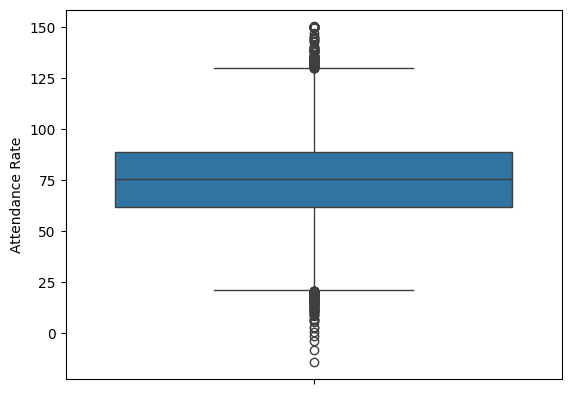

In [21]:
sns.boxplot(df['Attendance Rate'])

Довольно странно, что некоторые студенты имеют посещаемость более 100% (должно быть, сами добавляют пары в расписание или подрабатывают охранниками в вузе) -- данные явно ошибочные, их нужно отбросить. Также некоторые умудрились посетить отрицательное количество лекций.

In [22]:
df = df[df['Attendance Rate'] <= 100]

In [23]:
df = df[df['Attendance Rate'] >= 0]

<Axes: ylabel='Study Hours per Week'>

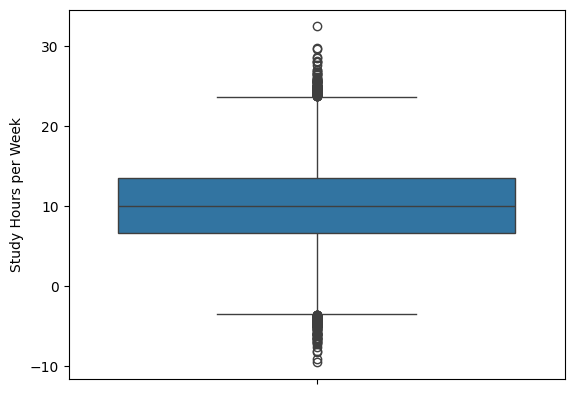

In [24]:
sns.boxplot(df['Study Hours per Week'])

Точно также отбросим строки, в которых студенты каким-то образом учатся отрицательное количество часов в неделю (0% осуждения, но это шум). Также, по box-plot, выбросы -- строки с показателем выше 23 часов

In [25]:
df = df[df['Study Hours per Week'] >= 0]

In [26]:
df = df[df['Study Hours per Week'] <= 23]

<Axes: ylabel='Previous Grades'>

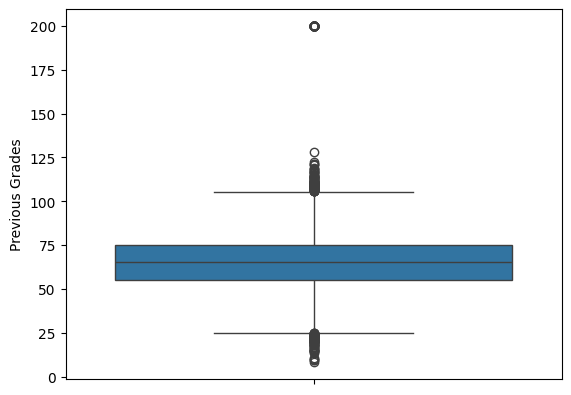

In [27]:
sns.boxplot(df['Previous Grades'])

В описании dataset есть информация о том, что оценки имеют диапазон от 0 до 100, поэтому, отбрасываем строки с иными значениями поля "Previous Grades":

In [28]:
df = df[df['Previous Grades'] <= 100]

Также по графику выбросами являются результаты ниже 25 баллов:


In [29]:
df = df[df['Previous Grades'] >= 25]

In [30]:
df.columns

Index(['Study Hours per Week', 'Attendance Rate', 'Previous Grades',
       'Participation in Extracurricular Activities_Yes',
       'Parent Education Level_Associate', 'Parent Education Level_Bachelor',
       'Parent Education Level_Doctorate',
       'Parent Education Level_High School', 'Parent Education Level_Master',
       'Passed_Yes'],
      dtype='object')

Последним шагом выделим target value:

In [31]:
target=df['Passed_Yes']
df=df.drop(['Passed_Yes'],axis=1)
df.head()

,Study Hours per Week,Attendance Rate,Previous Grades,Participation in Extracurricular Activities_Yes,Parent Education Level_Associate,Parent Education Level_Bachelor,Parent Education Level_Doctorate,Parent Education Level_High School,Parent Education Level_Master
1,9.3,95.3,60.6,False,False,False,False,True,False
3,17.6,76.8,62.4,True,False,True,False,False,False
4,8.8,89.3,72.7,False,False,False,False,False,True
5,8.8,73.8,69.3,True,False,False,False,True,False
6,17.9,38.6,93.6,False,False,False,True,False,False


In [32]:
target.value_counts()

,count
Passed_Yes,
False,15391
True,13814


И наконец выполним регуляризацию:

In [33]:
from sklearn.preprocessing import RobustScaler
rs = RobustScaler()
df=rs.fit_transform(df)
df = pd.DataFrame(df, columns = ['Study Hours per Week', 'Attendance Rate', 'Previous Grades',
       'Participation in Extracurricular Activities_Yes',
       'Parent Education Level_Associate', 'Parent Education Level_Bachelor',
       'Parent Education Level_Doctorate',
       'Parent Education Level_High School', 'Parent Education Level_Master'])
df.head()

,Study Hours per Week,Attendance Rate,Previous Grades,Participation in Extracurricular Activities_Yes,Parent Education Level_Associate,Parent Education Level_Bachelor,Parent Education Level_Doctorate,Parent Education Level_High School,Parent Education Level_Master
0,-0.121212,0.942149,-0.227273,0.0,0.0,0.0,0.0,1.0,0.0
1,1.136364,0.177686,-0.136364,1.0,0.0,1.0,0.0,0.0,0.0
2,-0.196970,0.694215,0.383838,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.196970,0.053719,0.212121,1.0,0.0,0.0,0.0,1.0,0.0
4,1.181818,-1.400826,1.439394,0.0,0.0,0.0,1.0,0.0,0.0


In [34]:
df

,Study Hours per Week,Attendance Rate,Previous Grades,Participation in Extracurricular Activities_Yes,Parent Education Level_Associate,Parent Education Level_Bachelor,Parent Education Level_Doctorate,Parent Education Level_High School,Parent Education Level_Master
0,-0.121212,0.942149,-0.227273,0.0,0.0,0.0,0.0,1.0,0.0
1,1.136364,0.177686,-0.136364,1.0,0.0,1.0,0.0,0.0,0.0
2,-0.196970,0.694215,0.383838,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.196970,0.053719,0.212121,1.0,0.0,0.0,0.0,1.0,0.0
4,1.181818,-1.400826,1.439394,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
29200,-0.757576,0.809917,-0.959596,1.0,0.0,0.0,1.0,0.0,0.0
29201,0.833333,0.880165,-0.691919,1.0,0.0,0.0,0.0,0.0,1.0
29202,0.181818,-0.252066,-0.045455,0.0,0.0,0.0,1.0,0.0,0.0
29203,0.454545,-0.285124,-1.363636,0.0,0.0,1.0,0.0,0.0,0.0


#Создание модели

In [35]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' # вычисления на графическом процессоре, если возможно
device

'cpu'

In [36]:
X=df
y=target

In [37]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', classes=[0,1], y=y)
class_weights = np.array([x for x in class_weights], dtype=np.float32)
class_weights

array([0.94876873, 1.0570798 ], dtype=float32)

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_dum, y_train, y_dum=train_test_split(X,y, test_size=0.2)
X_val, X_test, y_val, y_test= train_test_split(X_dum, y_dum ,test_size=0.5)

In [39]:
class MyDataset(Dataset):
  def __init__(self, data, targets, transform=None):
      #numpy_array = data.values
      self.data = torch.Tensor(data.values)
      self.targets = torch.LongTensor(targets.values)
      self.transform = transform

  def __getitem__(self, index):
      x = self.data[index]
      y = self.targets[index]
      return x, y

  def get_labels(self):
    return self.targets

  def __len__(self):
      return len(self.data)

In [40]:
train_dataset=MyDataset(X_train,y_train)
val_dataset=MyDataset(X_val,y_val)
test_dataset=MyDataset(X_test,y_test)

In [41]:
! pip install torchsampler

In [42]:
from torchsampler import ImbalancedDatasetSampler

In [43]:
batch_size=16 # размер пакета
train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=False,
                          sampler=ImbalancedDatasetSampler(train_dataset))
val_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

In [56]:
class Classification_Model_FFNN(nn.Module):
  def __init__(self, num_inputs, num_classes):
      super(Classification_Model_FFNN, self).__init__()
      self.pipe = nn.Sequential(
          nn.Linear(num_inputs, 32, bias=False),
          nn.ReLU6(inplace=True),
          nn.BatchNorm1d(32),

          nn.Linear(32, 16, bias=False),
          nn.ReLU6(inplace=True),
          nn.BatchNorm1d(16),

          nn.Linear(16, num_classes))

  def forward(self, x):
      return self.pipe(x)

In [57]:
model=Classification_Model_FFNN(9,2)
model.to(device)

Classification_Model_FFNN(
  (pipe): Sequential(
    (0): Linear(in_features=9, out_features=32, bias=False)
    (1): ReLU6(inplace=True)
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=32, out_features=16, bias=False)
    (4): ReLU6(inplace=True)
    (5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=16, out_features=2, bias=True)
  )
)

In [58]:
! pip install torchinfo

In [59]:
from torchinfo import summary
summary(model,input_size=(1, 9))

Layer (type:depth-idx)                   Output Shape              Param #
Classification_Model_FFNN                [1, 2]                    --
├─Sequential: 1-1                        [1, 2]                    --
│    └─Linear: 2-1                       [1, 32]                   288
│    └─ReLU6: 2-2                        [1, 32]                   --
│    └─BatchNorm1d: 2-3                  [1, 32]                   64
│    └─Linear: 2-4                       [1, 16]                   512
│    └─ReLU6: 2-5                        [1, 16]                   --
│    └─BatchNorm1d: 2-6                  [1, 16]                   32
│    └─Linear: 2-7                       [1, 2]                    34
Total params: 930
Trainable params: 930
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [60]:
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights))
#criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), weight_decay=0.1)

In [61]:
from tqdm import tqdm

In [62]:
def accuracy(predictions, labels):
    classes = torch.argmax(predictions, dim=1)
    return torch.mean((classes == labels).float())

In [63]:
train_losses=[]
train_accs=[]
def train(model,epoch):
  print('\nEpoch : %d'%epoch)
  model.train() # веса модели можно обновлять
  running_loss= 0.
  running_acc = 0.
  for data in tqdm(train_loader):
      inputs, targets=data[0].to(device),data[1].to(device) # распаковываем пакеты
      optimizer.zero_grad() # обнуляем градиенты
      outputs=model(inputs) # считаем предсказания - прямой проход модели
      loss=criterion(outputs,targets) # ошибка пакета
      loss.backward() # обратное распространение ошибки
      optimizer.step() # итерация алгоритма оптимизации

      running_loss += loss.item()
      running_acc += accuracy(outputs,targets)

  train_loss=running_loss/len(train_loader)
  train_acc=running_acc/len(train_loader)

  train_losses.append(train_loss)
  train_accs.append(train_acc)
  print('Средняя ошибка модели на тренировочной выборке: %.4f'%(train_loss)+'   Средняя точность модели на тренировочной выборке: %.4f'%(train_acc))

In [64]:
val_losses=[]
val_accs=[]
def val(model,epoch):
    print('\nEpoch : %d'%epoch)
    model.eval() # веса модели заморожены
    running_loss = 0.
    running_acc = 0.
    with torch.no_grad(): # запрещаем переисывать градиенты
        for data in tqdm(val_loader):
            inputs, targets=data[0].to(device),data[1].to(device)
            outputs=model(inputs)
            loss=criterion(outputs,targets)

            running_loss += loss.item()
            running_acc += accuracy(outputs,targets)

        val_loss=running_loss/len(val_loader)
        val_acc=running_acc/len(val_loader)

        val_losses.append(val_loss)
        val_accs.append(val_acc)
        print('Средняя ошибка модели на валидационной выборке: %.4f'%(val_loss)+'   Средняя точность модели на валидационной выборке: %.4f'%(val_acc))

In [65]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [66]:
max_epochs=100
best_acc=0.0
early_stopper = EarlyStopper(patience=5, min_delta=0.1)
for epoch in range(1,max_epochs+1):
    train(model,epoch)
    val(model,epoch)
    if val_accs[-1] > best_acc:
       torch.save(model, 'best-model.pt')
       best_acc = val_accs[-1]
    if early_stopper.early_stop(val_losses[-1]):
      break


Epoch : 1


100%|██████████| 1461/1461 [00:10<00:00, 141.25it/s]


Средняя ошибка модели на тренировочной выборке: 0.6973   Средняя точность модели на тренировочной выборке: 0.4977

Epoch : 1


100%|██████████| 183/183 [00:00<00:00, 1025.99it/s]


Средняя ошибка модели на валидационной выборке: 0.6945   Средняя точность модели на валидационной выборке: 0.4710

Epoch : 2


100%|██████████| 1461/1461 [00:02<00:00, 505.32it/s]


Средняя ошибка модели на тренировочной выборке: 0.6924   Средняя точность модели на тренировочной выборке: 0.4957

Epoch : 2


100%|██████████| 183/183 [00:00<00:00, 1789.88it/s]


Средняя ошибка модели на валидационной выборке: 0.6940   Средняя точность модели на валидационной выборке: 0.4696

Epoch : 3


100%|██████████| 1461/1461 [00:02<00:00, 499.99it/s]


Средняя ошибка модели на тренировочной выборке: 0.6915   Средняя точность модели на тренировочной выборке: 0.5045

Epoch : 3


100%|██████████| 183/183 [00:00<00:00, 1619.61it/s]


Средняя ошибка модели на валидационной выборке: 0.6945   Средняя точность модели на валидационной выборке: 0.4703

Epoch : 4


100%|██████████| 1461/1461 [00:03<00:00, 457.55it/s]


Средняя ошибка модели на тренировочной выборке: 0.6925   Средняя точность модели на тренировочной выборке: 0.4943

Epoch : 4


100%|██████████| 183/183 [00:00<00:00, 1498.70it/s]


Средняя ошибка модели на валидационной выборке: 0.6936   Средняя точность модели на валидационной выборке: 0.4710

Epoch : 5


100%|██████████| 1461/1461 [00:04<00:00, 350.38it/s]


Средняя ошибка модели на тренировочной выборке: 0.6911   Средняя точность модели на тренировочной выборке: 0.5082

Epoch : 5


100%|██████████| 183/183 [00:00<00:00, 962.38it/s]


Средняя ошибка модели на валидационной выборке: 0.6966   Средняя точность модели на валидационной выборке: 0.4706

Epoch : 6


100%|██████████| 1461/1461 [00:02<00:00, 493.61it/s]


Средняя ошибка модели на тренировочной выборке: 0.6911   Средняя точность модели на тренировочной выборке: 0.5074

Epoch : 6


100%|██████████| 183/183 [00:00<00:00, 1683.72it/s]


Средняя ошибка модели на валидационной выборке: 0.6952   Средняя точность модели на валидационной выборке: 0.4706

Epoch : 7


100%|██████████| 1461/1461 [00:02<00:00, 488.88it/s]


Средняя ошибка модели на тренировочной выборке: 0.6921   Средняя точность модели на тренировочной выборке: 0.4991

Epoch : 7


100%|██████████| 183/183 [00:00<00:00, 1779.10it/s]


Средняя ошибка модели на валидационной выборке: 0.6948   Средняя точность модели на валидационной выборке: 0.4703

Epoch : 8


100%|██████████| 1461/1461 [00:02<00:00, 493.42it/s]


Средняя ошибка модели на тренировочной выборке: 0.6914   Средняя точность модели на тренировочной выборке: 0.5053

Epoch : 8


100%|██████████| 183/183 [00:00<00:00, 1631.68it/s]


Средняя ошибка модели на валидационной выборке: 0.6946   Средняя точность модели на валидационной выборке: 0.4699

Epoch : 9


100%|██████████| 1461/1461 [00:04<00:00, 346.27it/s]


Средняя ошибка модели на тренировочной выборке: 0.6916   Средняя точность модели на тренировочной выборке: 0.5033

Epoch : 9


100%|██████████| 183/183 [00:00<00:00, 1186.59it/s]


Средняя ошибка модели на валидационной выборке: 0.6950   Средняя точность модели на валидационной выборке: 0.4710

Epoch : 10


100%|██████████| 1461/1461 [00:03<00:00, 438.49it/s]


Средняя ошибка модели на тренировочной выборке: 0.6916   Средняя точность модели на тренировочной выборке: 0.5037

Epoch : 10


100%|██████████| 183/183 [00:00<00:00, 643.47it/s]


Средняя ошибка модели на валидационной выборке: 0.6945   Средняя точность модели на валидационной выборке: 0.4713

Epoch : 11


100%|██████████| 1461/1461 [00:03<00:00, 481.79it/s]


Средняя ошибка модели на тренировочной выборке: 0.6916   Средняя точность модели на тренировочной выборке: 0.5037

Epoch : 11


100%|██████████| 183/183 [00:00<00:00, 1577.97it/s]


Средняя ошибка модели на валидационной выборке: 0.6945   Средняя точность модели на валидационной выборке: 0.4699

Epoch : 12


100%|██████████| 1461/1461 [00:02<00:00, 495.99it/s]


Средняя ошибка модели на тренировочной выборке: 0.6920   Средняя точность модели на тренировочной выборке: 0.5000

Epoch : 12


100%|██████████| 183/183 [00:00<00:00, 1546.58it/s]


Средняя ошибка модели на валидационной выборке: 0.6940   Средняя точность модели на валидационной выборке: 0.4710

Epoch : 13


 28%|██▊       | 416/1461 [00:00<00:02, 464.44it/s]


KeyboardInterrupt: 